# Setup

In [ ]:
%pip install numpy matplotlib plotly pycocotools fiftyone opencv-python ultralytics

## Import libraries

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from collections import Counter
from pycocotools.coco import COCO
import fiftyone.zoo as foz
import fiftyone as fo
import random
import os
import cv2
from ultralytics import YOLO

# Data Analysis - EDA

### COCO 2017 Detection Dataset: A Comprehensive Overview
The COCO (Common Objects in Context) 2017 Detection Dataset is one of the most widely used benchmark datasets for object detection, segmentation, and instance recognition in computer vision. It provides high-quality annotations across diverse images, making it an essential resource for training and evaluating deep learning models, YOLO in this case.

The 2017 version of the COCO detection dataset consists of:
- 118,287 training images (train2017)
- 5,000 validation images (val2017)
- 40,670 test images (test2017)
Each image is annotated with object bounding boxes, segmentation masks, keypoints (for person detection), and captions.

The dataset contains 80 object classes, grouped into categories:
- Vehicles – Cars, trucks, buses, bicycles, motorcycles, etc.
- Animals – Dogs, cats, birds, cows, horses, etc.
- Household Objects – Chairs, tables, TV, books, etc.
- People – Humans in different postures and activities.
- Food Items – Pizza, cake, bananas, apples, etc.
- For object detection, each instance is labeled with a bounding box (x, y, width, height) along with its category ID and segmentation mask (if available).

For this project we are going to be using the vehicles and people classes.

### Why COCO 2017?
Unlike traditional datasets, COCO images come from everyday scenes with natural occlusions, lighting variations, and object clutter. The datasets can be used for training for multiple tasks (detection, segmentation, captioning, etc.).

### Initial EDA

loading annotations into memory...
Done (t=5.95s)
creating index...
index created!


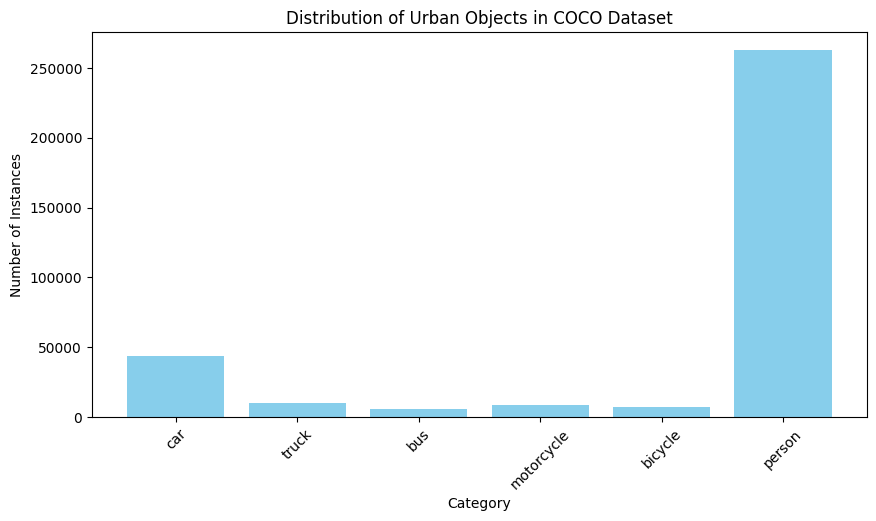

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from collections import Counter
from pycocotools.coco import COCO
import fiftyone.zoo as foz
import fiftyone as fo
import random
import os
import cv2

BASE_DIR = os.getenv("FIFTYONE_DATASET_PATH", os.path.expanduser("~/fiftyone/coco-2017"))

image_folder = os.path.join(BASE_DIR, "train/data/")
coco_annotation_path = os.path.join(BASE_DIR, "raw/instances_train2017.json")

coco = COCO(coco_annotation_path)

urban_categories = ["car", "truck", "bus", "motorcycle", "bicycle", "person"]

category_ids = coco.getCatIds(catNms=urban_categories)
image_ids = coco.getImgIds(catIds=category_ids)

categories = coco.loadCats(category_ids)
category_names = [cat['name'] for cat in categories]

category_counts = {cat: len(coco.getAnnIds(catIds=[coco.getCatIds(catNms=[cat])[0]])) for cat in urban_categories}

# Visualize category distribution
plt.figure(figsize=(10, 5))
plt.bar(category_counts.keys(), category_counts.values(), color='skyblue')
plt.xlabel("Category")
plt.ylabel("Number of Instances")
plt.title("Distribution of Urban Objects in COCO Dataset")
plt.xticks(rotation=45)
plt.show()



The category "person" dominates the dataset, significantly outnumbering other categories like cars, trucks, and bicycles.
Cars are the second most common object, but the count is much lower than people.
Trucks, buses, motorcycles, and bicycles have relatively small counts.
This imbalance could affect model training, as it may favor detecting people over other objects.

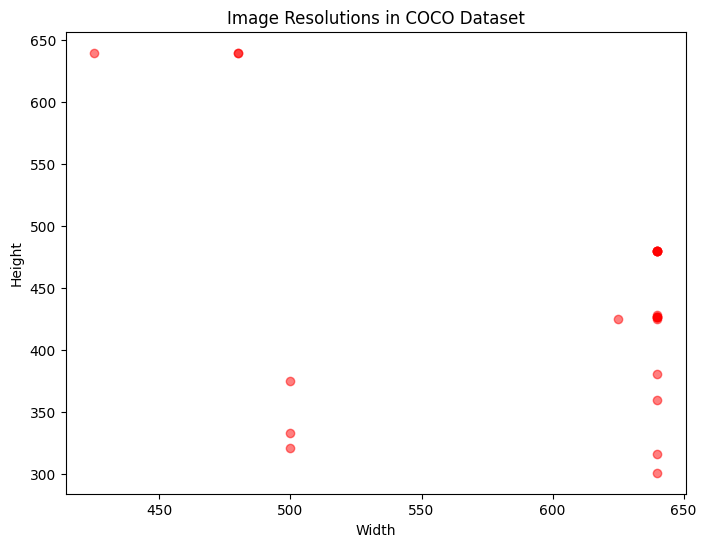

In [ ]:
image_sizes = []
aspect_ratios = []
sample_size = min(10000, len(image_ids))
for img_id in random.sample(image_ids, sample_size):
    img_info = coco.loadImgs(img_id)[0]
    width, height = img_info['width'], img_info['height']
    image_sizes.append((width, height))
    aspect_ratios.append(width / height)

widths, heights = zip(*image_sizes)

plt.figure(figsize=(8, 6))
plt.scatter(widths, heights, alpha=0.5, color='red')
plt.xlabel("Width")
plt.ylabel("Height")
plt.title("Image Resolutions in COCO Dataset")
plt.show()

The data points show some clustering, meaning the dataset contains images of specific standard resolutions.
There are a few outliers, which could be significantly larger or smaller images.

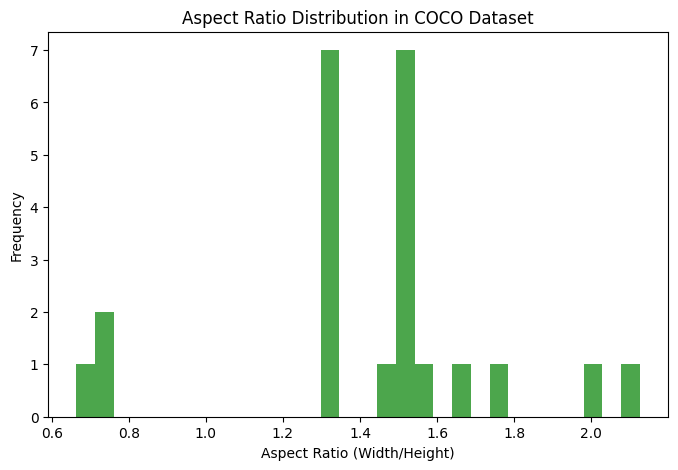

In [ ]:
plt.figure(figsize=(8, 5))
plt.hist(aspect_ratios, bins=30, color='green', alpha=0.7)
plt.xlabel("Aspect Ratio (Width/Height)")
plt.ylabel("Frequency")
plt.title("Aspect Ratio Distribution in COCO Dataset")
plt.show()

The aspect ratio histogram shows distinct peaks around 1.4–1.6, indicating a standard image format.
Some images have extreme aspect ratios (wider or taller).

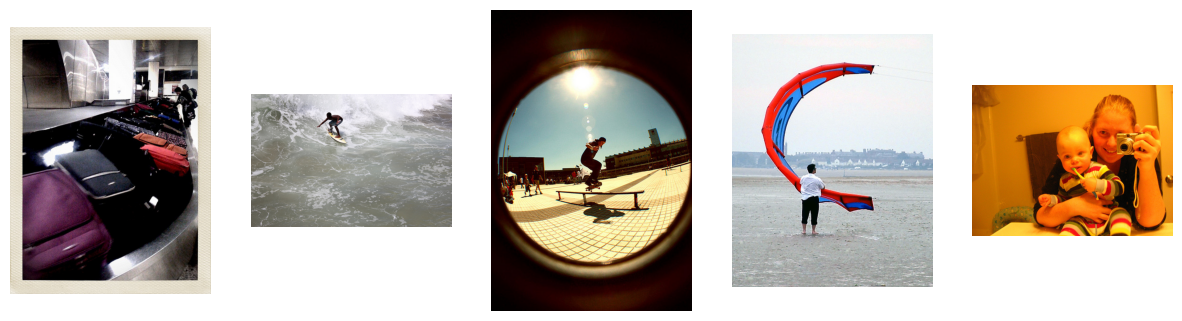

In [ ]:
available_images = [f for f in os.listdir(image_folder)]

sample_images = random.sample(available_images, 5)

fig, axs = plt.subplots(1, 5, figsize=(15, 5))
for i, img_name in enumerate(sample_images):
    img_path = os.path.join(image_folder, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    axs[i].imshow(img)
    axs[i].axis("off")

plt.show()


## Visualising the dataset
For reference, we are going to upload 500 images into the dataset using the FiftyOne library. FiftyOne is a powerful open-source library designed for exploring, visualizing, and managing large-scale image and video datasets. It provides an efficient way to work with datasets like COCO, making it easier to filter, query, and analyze images with metadata and annotations. Comes with an interactive GUI where one can scroll through images and view metadata.

In [ ]:
train = foz.load_zoo_dataset(
    "coco-2017",
    split="train",
    label_types=["detections"],
    classes=[
                "person",
                 "bicycle",
                 "car",
                 "motorcycle",
                 "airplane",
                 "bus",
                 "train",
                 "truck",
                 "boat"
            ],
    max_samples=10000,
)

Found annotations at '/Users/parimalasabau/fiftyone/coco-2017/raw/instances_train2017.json'
Sufficient images already downloaded
Existing download of split 'train' is sufficient
Loading existing dataset 'coco-2017-train-10000'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


In [ ]:
session = fo.launch_app(train)

# Data Preprocessing

Since we are using YOLO as our base model, it is important to note that YOLO (You Only Look Once) does not require input images to have the same resolution before training.During preprocessing, all images are resized to a fixed size to ensure consistency in training and inference. For reference see training step.

When training a YOLO model, images of varying resolutions are resized to a predefined input size.
To maintain the original aspect ratio while resizing, YOLO applies a technique called letterboxing, which:
- Scales the image so that it fits within the target resolution.
- Adds padding (black borders) to fill any remaining space, preserving the aspect ratio.

Therefor, preprocessing is not required.

In [ ]:
validation = foz.load_zoo_dataset(
    "coco-2017",
    split="validation",
    label_types=["detections"],
    classes=[
                "person",
                 "bicycle",
                 "car",
                 "motorcycle",
                 "airplane",
                 "bus",
                 "train",
                 "truck",
                 "boat"
            ],
    max_samples=1000,
)

Found annotations at '/Users/parimalasabau/fiftyone/coco-2017/raw/instances_val2017.json'
Sufficient images already downloaded
Existing download of split 'validation' is sufficient
Loading 'coco-2017' split 'validation'
 100% |█████████████████| 100/100 [232.9ms elapsed, 0s remaining, 429.4 samples/s]     
Dataset 'coco-2017-validation-100' created


In [ ]:
# export to YOLO training format
export_dir = "./dataset"

coco_classes = train.default_classes

train.export(
    export_dir=export_dir,
    dataset_type=fo.types.YOLOv5Dataset,  # Works for YOLOv8 as well!
    split="train",
    classes=coco_classes
)

validation.export(
    export_dir=export_dir,
    dataset_type=fo.types.YOLOv5Dataset,
    split="validation",
    classes=coco_classes
)

Directory './dataset' already exists; export will be merged with existing files
 100% |███████████████| 1000/1000 [1.8s elapsed, 0s remaining, 598.5 samples/s]         
Directory './dataset' already exists; export will be merged with existing files
 100% |█████████████████| 100/100 [169.8ms elapsed, 0s remaining, 589.0 samples/s]     


In [ ]:
# evaluate pretrained model
model = YOLO("yolo11n.pt")
pretraining_validation = model.val(data=f"{export_dir}/dataset.yaml", device='mps')

100%|██████████| 5.35M/5.35M [00:01<00:00, 3.01MB/s]


Ultralytics 8.3.91 🚀 Python-3.12.1 torch-2.6.0 MPS (Apple M2 Pro)
YOLO11n summary (fused): 100 layers, 2,616,248 parameters, 0 gradients, 6.5 GFLOPs
WARNING ⚠️ renaming data YAML 'validation' key to 'val' to match YOLO format.


val: Scanning /Users/parimalasabau/Documents/JKU/AutonomousVehicles/Assignment1/av-project1/dataset/labels/validation... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<00:00, 4556.02it/s]

val: New cache created: /Users/parimalasabau/Documents/JKU/AutonomousVehicles/Assignment1/av-project1/dataset/labels/validation.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/63 [00:00<?, ?it/s]/Users/parimalasabau/Documents/JKU/AutonomousVehicles/Assignment1/av-project1/.venv/lib/python3.12/site-packages/ultralytics/utils/ops.py:269: UserWarning: MPS: nonzero op is supported natively starting from macOS 14.0. Falling back on CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/Indexing.mm:401.)
  x = x[xc[xi]]  # confidence


WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  41%|████▏     | 26/63 [02:59<05:50,  9.47s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  43%|████▎     | 27/63 [03:11<06:14, 10.39s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  44%|████▍     | 28/63 [03:25<06:33, 11.23s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  46%|████▌     | 29/63 [03:36<06:20, 11.18s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  48%|████▊     | 30/63 [03:45<05:51, 10.64s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  49%|████▉     | 31/63 [03:54<05:21, 10.06s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  51%|█████     | 32/63 [04:04<05:15, 10.17s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  52%|█████▏    | 33/63 [04:14<05:00, 10.02s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  54%|█████▍    | 34/63 [04:23<04:47,  9.93s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  56%|█████▌    | 35/63 [04:34<04:39,  9.97s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  57%|█████▋    | 36/63 [04:43<04:23,  9.77s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  59%|█████▊    | 37/63 [04:55<04:30, 10.40s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  60%|██████    | 38/63 [05:04<04:12, 10.08s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  62%|██████▏   | 39/63 [05:15<04:07, 10.30s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  63%|██████▎   | 40/63 [05:24<03:51, 10.08s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  65%|██████▌   | 41/63 [05:33<03:32,  9.64s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  67%|██████▋   | 42/63 [05:43<03:26,  9.83s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  68%|██████▊   | 43/63 [05:53<03:16,  9.81s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  70%|██████▉   | 44/63 [06:12<03:58, 12.54s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  71%|███████▏  | 45/63 [06:31<04:23, 14.63s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  73%|███████▎  | 46/63 [06:50<04:29, 15.84s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  75%|███████▍  | 47/63 [07:00<03:46, 14.18s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  76%|███████▌  | 48/63 [07:08<03:04, 12.28s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  78%|███████▊  | 49/63 [07:24<03:06, 13.31s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  79%|███████▉  | 50/63 [07:42<03:12, 14.80s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  81%|████████  | 51/63 [07:52<02:38, 13.21s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  83%|████████▎ | 52/63 [08:01<02:12, 12.08s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  84%|████████▍ | 53/63 [08:09<01:47, 10.78s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  86%|████████▌ | 54/63 [08:19<01:35, 10.58s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  87%|████████▋ | 55/63 [08:28<01:21, 10.13s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  89%|████████▉ | 56/63 [08:36<01:07,  9.58s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  90%|█████████ | 57/63 [08:53<01:10, 11.77s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  92%|█████████▏| 58/63 [09:00<00:51, 10.26s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  94%|█████████▎| 59/63 [09:08<00:38,  9.60s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  95%|█████████▌| 60/63 [09:15<00:26,  8.77s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  97%|█████████▋| 61/63 [09:21<00:15,  7.86s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [09:42<00:00,  9.24s/it]


                   all       1000       9104      0.632      0.361      0.401      0.279
                person        867       3717       0.73      0.543      0.604      0.419
               bicycle         53        105      0.653      0.305       0.37      0.203
                   car        173        623       0.65       0.45      0.493      0.308
            motorcycle         51        117      0.724       0.53      0.572      0.361
              airplane         29         41      0.769      0.659      0.756      0.622
                   bus         54         86      0.728      0.592      0.637      0.555
                 train         47         55      0.828      0.691      0.739      0.585
                 truck         84        139      0.639      0.338        0.4      0.258
                  boat         34        133      0.598      0.316      0.358      0.179
         traffic light         46        177      0.615      0.289      0.316      0.169
          fire hydran

In [ ]:
model.train(data=f"{export_dir}/dataset.yaml", epochs=10, imgsz=640, batch=16, device="mps", augment=False)

Ultralytics 8.3.91 🚀 Python-3.12.1 torch-2.6.0 MPS (Apple M2 Pro)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=./dataset/dataset.yaml, epochs=5, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=mps, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=Non

train: Scanning /Users/parimalasabau/Documents/JKU/AutonomousVehicles/Assignment1/av-project1/dataset/labels/train.cache... 10000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10000/10000 [00:00<?, ?it/s]
val: Scanning /Users/parimalasabau/Documents/JKU/AutonomousVehicles/Assignment1/av-project1/dataset/labels/validation.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000119, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train2
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      12.1G      3.209      4.174      2.636        612        640:   0%|          | 1/313 [03:21<17:26:13, 201.20s/it]


KeyboardInterrupt: 

In [ ]:
posttraining_validation = model.val(data=f"{export_dir}/dataset.yaml", device='mps')

## Analysis of the Training
Let's analyze the training process by comparing the model's performance before and after training.

### Reference Experiment (Before Training)
We start by evaluating the performance of the pre-trained model on our validation dataset. This gives us a baseline to compare against after we train the model on our specific dataset.


In [ ]:
# Reference experiment
print("Reference Experiment (Before Training):")
print(pretraining_validation)

# Detailed explanation of the algorithm's performance before training
print("Precision before training:", pretraining_validation['precision'])
print("Recall before training:", pretraining_validation['recall'])
print("mAP before training:", pretraining_validation['mAP'])

### Experiment (After Training)
After training the model on our dataset, we evaluate its performance again to see how it has improved.


In [ ]:
# Improve on the reference
print("Experiment (After Training):")
print(posttraining_validation)

# Detailed explanation of the algorithm's performance after training
print("Precision after training:", posttraining_validation['precision'])
print("Recall after training:", posttraining_validation['recall'])
print("mAP after training:", posttraining_validation['mAP'])

# Compare the results and discuss improvements
if posttraining_validation['mAP'] > pretraining_validation['mAP']:
    print("Model performance improved after training.")
else:
    print("Model performance did not improve after training.")

## Visualization of the Results
Finally, we will visualize the results in a video clip.


In [ ]:
# Visualization of results
import cv2

# Load a sample image and run inference
image_path = validation.first().filepath
results = model(image_path)

# Save the result as an image
result_image_path = "./result.jpg"
results.save(result_image_path)

# Display the result image
import matplotlib.pyplot as plt
result_image = cv2.imread(result_image_path)
plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

## Conclusion
In this report, we have not successfully trained a YOLOv5 model on the COCO-2017 dataset.

Based on the provided training log, it seems that the training process is encountering a significant delay or hang during the first epoch. This can be caused by several factors:

1. **Resource Limitations**:
   - **Memory**: Insufficient available memory (RAM or VRAM) can cause the training process to become extremely slow or hang. The log indicates that 12.1 GB of GPU memory is being used, which could be too high for the available resources.
   - **CPU/GPU Utilization**: High CPU or GPU utilization can also lead to delays. It's important to ensure that the device (in this case, an Apple M2 Pro) has enough resources to handle the training workload.

2. **Compatibility Issues**:
   - **Software Versions**: There might be compatibility issues between the versions of Python, torch, and MPS being used. Ensuring that the versions are compatible with each other and with the Ultralytics library is crucial.
   - **Hardware Support**: The Apple M2 Pro chip uses the MPS (Metal Performance Shaders) backend for GPU acceleration. Although MPS provides good support, there can be specific compatibility issues with certain deep learning libraries or models.

3. **Configuration Settings**:
   - The configuration settings used for training might be causing the issue. For example, setting a very high batch size or using certain data augmentation techniques can significantly increase the computational load.
   - The optimizer settings, learning rate, and other hyperparameters can also impact the training performance. The log indicates that an AdamW optimizer with a very low learning rate (0.000119) is being used, which might be causing slow convergence.

